In [ ]:
import sys
patch_size = 33
parentpath= '/home/koyama-m/Research/membrane_CNN/'
modelpath='/home/koyama-m/Research/membrane_CNN/models/'
datapath_train = '/home/koyama-m/Research/membrane_CNN/data/training_dataset/256_training_dataset_crop%s/' %str(patch_size)
datapath_test = '/home/koyama-m/Research/membrane_CNN/data/test_dataset/256_test_dataset_crop%s/' %str(patch_size)
label_datapath_train = '/home/koyama-m/Research/membrane_CNN/data/training_dataset/label_256_training_dataset_crop%s/'%str(patch_size)
label_datapath_test = '/home/koyama-m/Research/membrane_CNN/data/test_dataset/label_256_test_dataset_crop%s/'%str(patch_size)

trainingfilepath_prefix = '256_training_image_'   #256_test_image_%3d%3d%3d.tif %(slice_index, row, column)
label_filepath_prefix = 'label_256_training_image_' 
sys.path.append(parentpath)
sys.path.append(modelpath)
sys.path.append(datapath_train)
sys.path.append(datapath_test)

sys.path.append(label_datapath_train)
sys.path.append(label_datapath_test)

sys.path.append(trainingfilepath_prefix)
sys.path.append(label_filepath_prefix)
import chainer
import chainer.functions as F
from chainer import cuda, Function, FunctionSet, gradient_check, Variable, optimizers

import load_preprocessed_data_set as loadt 
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline
reload(loadt)

In [ ]:
cropsize = patch_size
boringsize = 0
#dataslice_test = loadt.make_data_set(datapath_test,  patchsize =patch_size ,label_data_path = label_datapath_test, is_training = False, boring_size = 2)
#dataslice_train = loadt.make_data_set(datapath_train, patchsize =patch_size ,label_data_path = label_datapath_train, is_training = True, boring_size = 2)
#dataset = pickle.load(open('/home/koyama-m/Research/membrane_CNN/data/temp_data/temp_dataset_with_hole.pkl','rb')) 

dataslice_test = loadt.make_data_set(datapath_test,  patchsize =cropsize ,label_data_path = label_datapath_test, is_training = False, boring_size = boringsize)
dataslice_train = loadt.make_data_set(datapath_train, patchsize =cropsize ,label_data_path = label_datapath_train, is_training = True, boring_size = boringsize)

dataslice_test = dataset['test'] 
dataslice_train= dataset['train'] 

(189351, 15, 15)
7 0.0


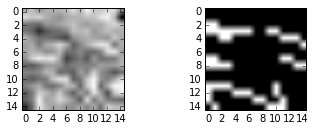

In [8]:
print dataslice_train['x_data'].shape
crop_index = 109002
plt.subplot(2,2,1)
plt.imshow(dataslice_train['x_data'][crop_index], cmap = plt.cm.gray)
plt.subplot(2,2,2)
plt.imshow(dataslice_train['label_x_data'][crop_index], cmap = plt.cm.gray)
center = (patch_size -1)/2
print center, dataslice_train['label_x_data'][crop_index][center][center]
#print dataslice['label_x_data'][crop_index]
#plt.imshow(Image.fromarray(np.uint8(dataslice['label_x_data'][crop_index])))

In [160]:
def reshape_for_chainer_cnn(dataslice_train,  dataslice_test):

    x_train0 = dataslice_train['x_data']/255.
    x_train0_label = dataslice_train['label_x_data']/255.
    y_train0 = dataslice_train['y_data']
    pre_x_test = dataslice_test['x_data']/255.
    pre_x_test_label = dataslice_test['label_x_data']/255.
    pre_y_test = dataslice_test['y_data']        

    print 'COMPLETE \n '

    ##### Validation Set and  the rest #### 

    print 'Preparing the Validation data... '
    neg_index = np.where(y_train0 == 0)[0]
    pos_index = np.where(y_train0 == 1)[0]
    neg_pos_prop = [neg_index.shape[0], pos_index.shape[0] ]
    print neg_pos_prop

    print 'Pos Neg proportion in training data is' + str(neg_pos_prop)

    validate_index = np.arange(150000, y_train0.shape[0],1)
    train_index  = np.arange(0,150000,1)
    print 'Validation data size is  ' + str(validate_index.shape[0])

    pre_x_valid = x_train0[validate_index]
    pre_x_valid_label = x_train0_label[validate_index]
    pre_y_valid = y_train0[validate_index]
    pre_x_train = x_train0[train_index]
    pre_x_train_label = x_train0_label[train_index]
    pre_y_train = y_train0[train_index]

    print 'COMPLETE \n '

    print 'Reshaping the dataset '
    ##### reshape x for cnn  #####


    x_train = np.zeros((pre_x_train.shape[0], 2,pre_x_train.shape[1],pre_x_train.shape[1]))
    x_train[:,0,:,:] = pre_x_train
    x_train[:,1,:,:] = pre_x_train_label       

    x_test = np.zeros((pre_x_test.shape[0], 2, pre_x_test.shape[1],pre_x_test.shape[1]))
    x_test[:,0,:,:] = pre_x_test
    x_test[:,1,:,:] = pre_x_test_label    

    x_valid = np.zeros((pre_x_valid.shape[0], 2, pre_x_valid.shape[1],pre_x_valid.shape[1]))
    x_valid[:,0,:,:] = pre_x_valid
    x_valid[:,1,:,:] = pre_x_valid_label       

    y_train = pre_y_train
    y_test  = pre_y_test
    y_valid = pre_y_valid 

    return x_train, x_test, x_valid, y_train, y_test, y_valid

In [220]:
x_train, x_test, x_valid, y_train, y_test, y_valid = reshape_for_chainer_cnn(dataslice_train,  dataslice_test)        

def filter_batch(batch, temperature):
    k = 0
    filtered_batch = batch.copy()
    for pic in batch:
        pic = ndi.filters.gaussian_filter(pic, temperature)
        #filtered_batch[k] = pic
        batch[k] = pic
        k = k +1
    #return batch
    #return 0

COMPLETE 
 
Preparing the Validation data... 
[94676, 94675]
Pos Neg proportion in training data is[94676, 94675]
Validation data size is  39351
COMPLETE 
 
Reshaping the dataset 


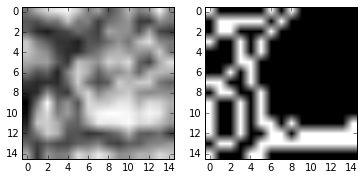

In [229]:
temperature = 0
i = 23
minibatchsize = 50
batchrange = indexes[i : i + minibatchsize]
x_train_batch = x_train[batchrange]
batch_index = 23

plt.subplot(1,2,1)
plt.imshow(x_train_batch[batch_index,0,:,:], cmap = plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(x_train_batch[batch_index,1,:,:], cmap = plt.cm.gray)




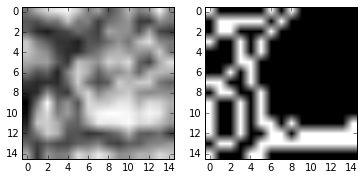

In [230]:
x_train_batch.shape
filter_batch(x_train_batch[:,1,:,:] , temperature)
plt.subplot(1,2,1)
plt.imshow(x_train_batch[batch_index,0,:,:], cmap = plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(x_train_batch[batch_index,1,:,:], cmap = plt.cm.gray)

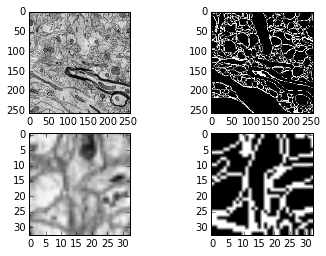

In [4]:
filename = 'edgemap001.tif'
filename2 = 'pooled_image_001.tif'

label_data_dir  = 'raw/train-labels'
raw256path ="preprocessed/training/pooled_training_dataset"

corner_x = 1
corner_y = 45
patchsize = 33
patch_range = (corner_x, corner_y, corner_x + patchsize, corner_y + patchsize )

testimage= testimage_patch= Image.open("%s/data/%s/%s" % (parentpath, raw256path, filename2))
testlabel =Image.open("%s/data/%s/%s" % (parentpath, label_data_dir, filename))
testimage_patch= Image.open("%s/data/%s/%s" % (parentpath, raw256path, filename2)).crop(patch_range)
testlabel_patch= Image.open("%s/data/%s/%s" % (parentpath, label_data_dir, filename)).crop(patch_range)

plt.subplot(2,2,1)
plt.imshow(testimage, cmap = plt.cm.gray)
plt.subplot(2,2,2)
plt.imshow(testlabel, cmap = plt.cm.gray)

plt.subplot(2,2,3)
plt.imshow(testimage_patch, cmap = plt.cm.gray)
plt.subplot(2,2,4)
plt.imshow(testlabel_patch, cmap = plt.cm.gray)




In [5]:
x_data_im =dataslice_train['x_data'][crop_index]
x_data_label = dataslice_train['label_x_data'][crop_index]
x = chainer.Variable(x_data_label, volatile=False)

In [6]:
x_train0 = dataslice_train['x_data']/255.
x_train0_label = dataslice_train['label_x_data']/255.
y_train0 = dataslice_train['y_data']


x_test = dataslice_test['x_data']/255.
x_test_label = dataslice_test['label_x_data']/255.
y_test = dataslice_test['y_data']



In [7]:
import numpy as np
neg_index = np.where(y_train0 == 0)[0]
pos_index = np.where(y_train0 == 1)[0]
neg_pos_prop = [neg_index.shape[0], pos_index.shape[0] ]
print neg_pos_prop

validate_index = np.arange(150000, y_train0.shape[0],1)
train_index  = np.arange(0,150000,1)
print validate_index.shape[0]

x_valid = x_train0[validate_index]
x_valid_label = x_train0_label[validate_index]
y_valid = y_train0[validate_index]
pre_x_train = x_train0[train_index]
pre_x_train_label = x_train0_label[train_index]
y_train = y_train0[train_index]

[94676, 94675]
39351


In [8]:
trialsize = 200
print pre_x_train_label.shape
#x_train= np.zeros((pre_x_train.shape[0], 2,pre_x_train.shape[1],pre_x_train.shape[1]))
x_train= np.zeros((trialsize, 2,pre_x_train.shape[1],pre_x_train.shape[1]))

x_train.shape, pre_x_train[0:trialsize].shape, pre_x_train_label[0:trialsize].shape

(150000, 15, 15)


((200, 2, 15, 15), (200, 15, 15), (200, 15, 15))

In [9]:

#x_train_formatted = np.zeros((x_train.shape[0], 2,x_train.shape[1],x_train.shape[1]))

x_train[0:trialsize,0,:,:] = pre_x_train[0:trialsize]
x_train[0:trialsize,1,:,:] = pre_x_train_label[0:trialsize]

x_train.shape

(200, 2, 15, 15)

In [10]:
patchsize = 15
channel1 = 20.
filtsize1 = 5. #3
padsize1 = 0.
poolsize1 = 1.
stride1 = 1.

channel2 = 50.
filtsize2 = 5. #3
padsize2 = 0.
poolsize2= 1.
stride2 = 1.

num_categ = 2


size1 = patchsize - (filtsize1 -1)+ padsize1 *2.
size2 = np.ceil(size1/poolsize1)
size3 = size2 - (filtsize2 -1)+ padsize2 *2.
size4 = np.ceil(size3/poolsize2)
sizef = size4**2*channel2       

conv1 = F.Convolution2D(2,int(channel1), int(filtsize1))
conv2 = F.Convolution2D(int(channel1),int(channel2),int(filtsize2),pad=0)
fc3 = F.Linear(int(size4)**2*int(channel2),int(size4)**2*int(channel2))
fcf = F.Linear(int(size4)**2*int(channel2), num_categ)


print patchsize
print size2
print size3
print size4
print int(size4)**2*int(channel2)

15
11.0
7.0
7.0
2450


In [11]:
x_train = np.float32(x_train)
x_data = chainer.Variable(x_train, volatile=False)
x_data.data.shape, type(x_data), x_train.dtype

((200, 2, 15, 15), chainer.variable.Variable, dtype('float32'))

In [12]:
conv1(x_data)

In [13]:
out1 = F.relu(conv1(x_data))
print out1.data.shape
out2 = F.dropout(F.relu(conv2(out1)))
print out2.data.shape
out3 = F.dropout(F.relu(fc3(out2)))
out4 = fcf(out3)
print out4.data.shape
pred = F.softmax(out4)

(200, 20, 11, 11)
(200, 50, 7, 7)
(200, 2)


In [14]:
type(conv2)

chainer.functions.convolution_2d.Convolution2D

In [21]:
def augment_data_batch(self, xtrain_batch, ytrain_batch):


    x_batch_orig = x_train_batch
    y_batch_orig = y_train_batch
    x_batch_tr = np.transpose(x_train_batch, (0,1,3,2))
    y_batch_tr = y_batch_orig
    x_batch_lr  = x_train_batch[:,:,:,::-1]
    y_batch_lr  = y_batch_orig
    x_batch_ud  = x_train_batch[:,:,::-1,:]
    y_batch_ud  = y_batch_orig
    x_batch_udtr = np.transpose(x_batch_ud, (0,1,3,2)) 
    y_batch_udtr = y_batch_orig

    pre_x_batch = np.float32(np.concatenate((x_batch_orig,x_batch_tr, x_batch_lr, x_batch_ud, x_batch_udtr), axis=0))
    pre_y_batch = np.int32(np.concatenate((y_batch_orig,y_batch_tr, y_batch_lr, y_batch_ud,y_batch_udtr), axis=0)) 

    return pre_x_batch, pre_y_batch


In [34]:
import time
cuda.init()
trainsize = x_train.shape[0]
validsize = x_valid.shape[0]
start_time = time.time()

minibatchsize = 50

indexes = np.random.permutation(trainsize)
n_batch = indexes.shape[0]/minibatchsize
sum_loss = 0
sum_accuracy = 0

i = 0
batchrange = indexes[i : i + minibatchsize]
x_train_batch = x_train[batchrange]
y_train_batch = y_train[batchrange]

pre_x_batch, pre_y_batch = augment_data_batch(x_train_batch, y_train_batch, i)
#x_batch = cuda.to_gpu(pre_x_batch)
#y_batch = cuda.to_gpu(pre_y_batch)  
x_batch = pre_x_batch
y_batch = pre_y_batch
x_batch.dtype,  y_batch.dtype
x_batch.shape, y_batch.shape
x_batch.ndim, y_batch.ndim

(4, 1)

In [29]:
x_batch.shape
y_batch.shape

(250,)

In [30]:
import convnet_conditional
reload(convnet_conditional)
from convnet_conditional import convnet_cdd as cdd
model_cpu_ver = cdd(patchsize=x_train.shape[2])
model =  cdd(patchsize=x_train.shape[2]).to_gpu()



final feature map dimension before the softmax 7.0
final feature map dimension before the softmax 7.0


In [31]:
model_cpu_ver.forward(x_batch, y_batch)

(<chainer.variable.Variable at 0x7f302cadee90>,
 <chainer.variable.Variable at 0x7f302cadeb90>)

In [258]:
image_size = 256 
crop_size = 15
stride = 3
for k in xrange(int((image_size - crop_size) / stride)):
    print k

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


In [6]:
from time import gmtime, strftime
import datetime
print strftime("%Y-%m-%d %H:%M:%S", gmtime())

2015-08-07 15:19:18


In [9]:
print str(datetime.datetime.now())

2015-08-08 00:19:37.386633
